In [1]:
%load_ext autoreload
%autoreload 2

# Descriptive Figures 
This notebook contains the needed code to replicate the following plots in the paper: 
 - Figure 1 elements: We generate here individual plots that we later assembled in Adobe Illustrator. 
 - Supplementary Figure 5: Comparisons with Fire Intensity/

In [2]:
import matplotlib
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from prescribed.plot import template_plots, data_fire_plot

# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Helvetica Neue"

# Set the font size to be 12
plt.rcParams["font.size"] = 12


matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

### Load needed datasets for all the panels

In [3]:
ca_geom = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/california_geom/datacalifornia_geom.shp"
).to_crs("EPSG:3310")


mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)

mtbs_ca = mtbs[mtbs.Event_ID.str.startswith("CA")].to_crs(3310)
mtbs_ca["Ig_Date"] = pd.to_datetime(mtbs_ca.Ig_Date)
mtbs_ca["year"] = mtbs_ca.Ig_Date.dt.year

In [4]:
# Intensity
frp = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/frp_nominal_conf/frp_concat.feather"
)

# Severity
dnbr = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee_inmediate/dnbr_long.feather"
)
dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year"]],
    left_on="event_id",
    right_on="Event_ID",
    how="left",
)
dnbr["dnbr"] = np.where(dnbr["dnbr"] < 0, 0, dnbr["dnbr"])

dnbr["prescribed"] = (
    dnbr["event_id"]
    .isin(mtbs_ca[mtbs_ca.Incid_Type == "Prescribed Fire"].Event_ID.tolist())
    .astype(np.int8)
)

In [5]:
treatment = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/treatments_mtbs.feather"
)

frp_agg = (
    frp.merge(
        treatment[(treatment.Event_ID != "nodata") & (treatment.year >= 2001)],
        on=["lat", "lon", "year"],
        how="inner",
    )
    .groupby("Event_ID")
    .frp.agg(["mean", "sum"])
)

frp_agg.columns = ["mean_frp", "sum_frp"]
frp_agg.reset_index(inplace=True)

In [6]:
event_id = "CA3720111927220200905"
fire = data_fire_plot(
    frp=frp,
    dnbr=dnbr,
    wide_treats="/mnt/sherlock/oak/prescribed_data/processed/wide_treatments_gee_inmediate/wide_treats_mtbs.feather",
    emissions=None,
    mtbs=mtbs_ca,
    year=2020,
    event_id=event_id,
)

fires = data_fire_plot(
    frp=frp,
    dnbr=dnbr,
    wide_treats="/mnt/sherlock/oak/prescribed_data/processed/wide_treatments_gee_inmediate/wide_treats_mtbs.feather",
    emissions=None,
    mtbs=mtbs_ca,
)

/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


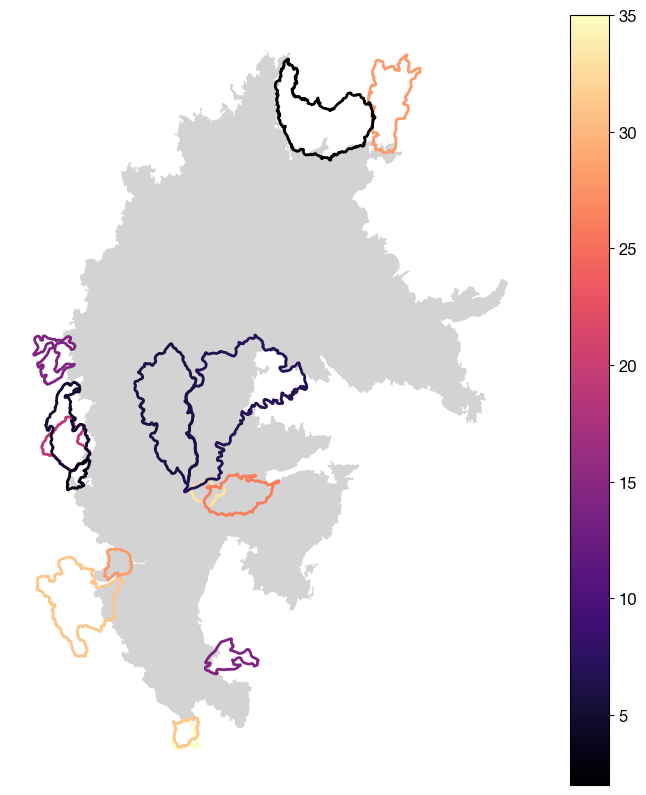

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))


mtbs_ca[mtbs_ca.Event_ID == "CA3720111927220200905"].plot(
    ax=ax, color="lightgray"
)


int_past_fires = mtbs_ca[
    (mtbs_ca.Event_ID != "CA3720111927220200905")
    & (
        mtbs_ca.geometry.intersects(
            mtbs_ca[mtbs_ca.Event_ID == "CA3720111927220200905"].geometry.iloc[
                0
            ]
        )
    )
]
int_past_fires["year_fire"] = 2020
int_past_fires["year_delta"] = int_past_fires.year_fire - int_past_fires.year

int_past_fires.plot(
    column="year_delta",
    cmap="magma",
    ax=ax,
    linewidth=2,
    facecolor="none",
    legend=True,
)
ax.axis("off")

# Save the figure as PDF
plt.savefig(
    "../figs/creek_fire_history.pdf",
    bbox_inches="tight",
    dpi=400,
    transparent=True,
)

/tmp/ipykernel_466532/2468620163.py:57: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  fire_l8.rio.reproject("EPSG:3310").drop("spatial_ref").plot.imshow(
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/tmp/ipykernel_466532/2468620163.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


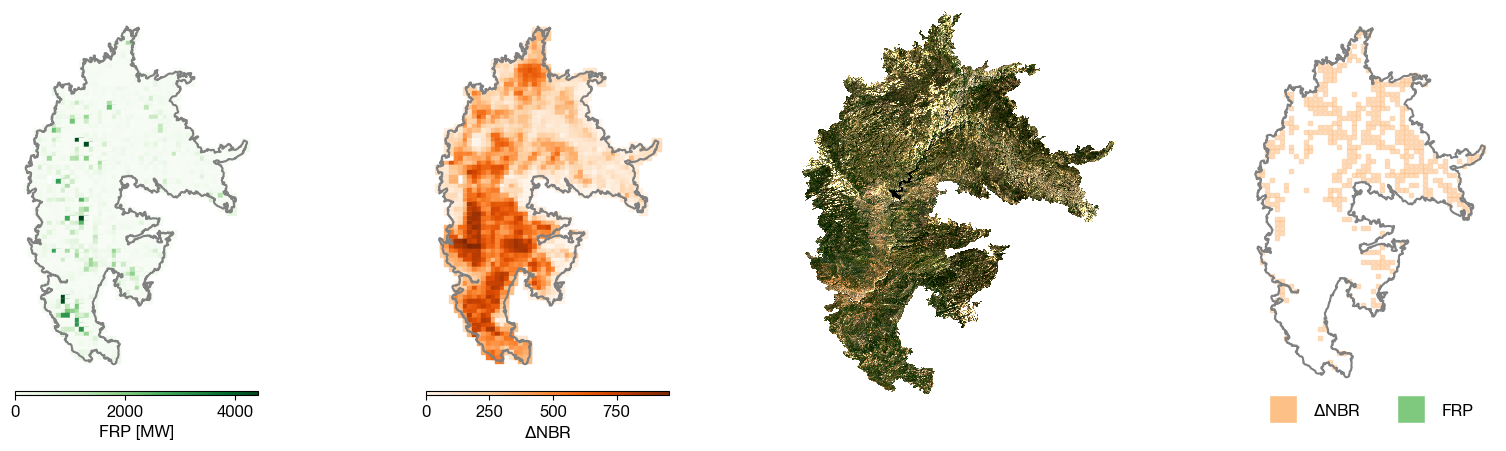

In [11]:
# Create a figure with a grid layout
fig = plt.figure(figsize=(20, 5))
gs = fig.add_gridspec(1, 4, wspace=0.3)

# Create subplots
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[3])
ax = [ax0, ax1, ax2, ax3]

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="1%", pad=0.1)

mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax[0], color="Grey")

# Plot with divergent color scheme
ax[0] = fire.plot(
    column="frp",
    legend=True,
    cmap="Greens",
    marker=",",
    ax=ax[0],
    cax=cax,
    legend_kwds={"label": "FRP [MW]", "orientation": "horizontal"},
)

template_plots(ax[0], xlab="", ylab="", no_axis=True)


# Take care of the colorbar size
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("bottom", size="1%", pad=0.1)


mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax[1], color="Grey")

# Plot with divergent color scheme
fire.plot(
    column="dnbr",
    legend=True,
    cmap="Oranges",
    ax=ax[1],
    marker=",",
    cax=cax,
    legend_kwds={"label": r"$\Delta$NBR", "orientation": "horizontal"},
)
template_plots(ax[1], xlab="", ylab="", no_axis=True)


# Plot Landsat 8
divider = make_axes_locatable(ax[2])

fire_l8 = rioxarray.open_rasterio(
    "pre/CA3720111927220200905.tif"
).rio.write_crs(4326)
fire_l8.rio.reproject("EPSG:3310").drop("spatial_ref").plot.imshow(
    robust=True, ax=ax[2]
)

template_plots(ax[2], xlab="", ylab="", no_axis=True)

# Plot emissions
mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax[3], color="Grey")

# Plot with divergent color scheme
fire[fire.treat_severity == 1].plot(
    marker=",", legend=False, ax=ax[3], color="#fdc086", alpha=0.5, markersize=8
)

template_plots(ax[3], xlab="", ylab="", no_axis=True)

ax[3].legend(
    [
        plt.Line2D(
            [1],
            [0],
            marker="s",
            color="w",
            markerfacecolor="#fdc086",
            markersize=20,
        ),
        plt.Line2D(
            [1],
            [10],
            marker="s",
            color="w",
            markerfacecolor="#7fc97f",
            markersize=20,
        ),
    ],
    [
        r"$\Delta$NBR",
        "FRP",
    ],
    fontsize=12,
    frameon=False,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
)

plt.tight_layout()

# Save plot to svg
plt.savefig(
    "../figs/fire_plot.pdf",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

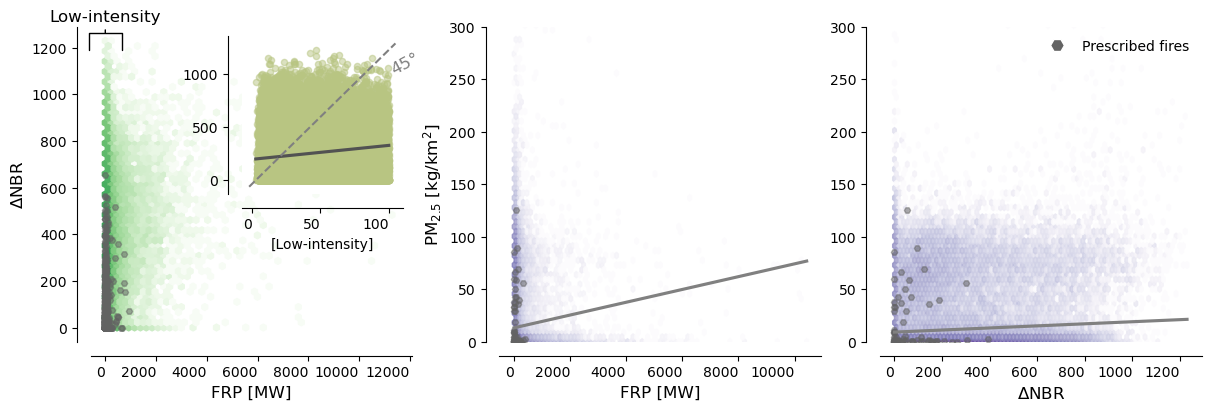

In [18]:
# For illustrator to understand the font, we need to pass this!
import matplotlib
from matplotlib.gridspec import GridSpecFromSubplotSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(12, 4), layout="compressed")
spec = fig.add_gridspec(1, 3)

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

################################################################################
########################### DNBR and FRP relationship ##########################
################################################################################

ax = fig.add_subplot(spec[0, 0])

# Create an inset plot to the main plot located to the top right
axins = inset_axes(ax, width="50%", height="50%", loc=1)

# Transform the data to plot a 2-d hexbin using matplotlib
fires.plot.hexbin(
    x="frp",
    y="dnbr",
    cmap="Greens",
    ax=ax,
    gridsize=50,
    bins="log",
    colorbar=False,
)

# Plot the prescribed fires in gray
fires[(fires["prescribed"] == 1)].plot.scatter(
    x="frp",
    y="dnbr",
    c="#636363",
    ax=ax,
    alpha=0.5,
    colorbar=False,
    fontsize=10,
    marker="H",
)

template_plots(ax, xlab="FRP [MW]", ylab=r"$\Delta$NBR")


# Insert an annotation with an arrowprop
ax.annotate(
    "Low-intensity",
    xy=(0, 1250),
    xytext=(0, 1300),
    ha="center",
    va="bottom",
    fontsize=12,
    arrowprops=dict(arrowstyle="-[, widthB=1.0, lengthB=1.0", lw=1, color="k"),
)

# Inlet plot
plt.rcParams.update({"font.size": 14})
fires[fires["treat_intensity"] == 1].plot.scatter(
    x="frp",
    y="dnbr",
    c="#B8C582",
    ax=axins,
    alpha=0.5,
    colorbar=False,
    fontsize=10,
)

sns.regplot(
    x="frp",
    y="dnbr",
    data=fires[fires["treat_intensity"] == 1],
    scatter=False,
    ax=axins,
    color="#525252",
    robust=False,
)
template_plots(axins, xlab="", ylab="", diag=True)

# Add text in the same color over the 45-degree.
axins.text(100, 1000, "45°", rotation=28, color="gray", fontsize=12)
axins.set_title("[Low-intensity]", fontsize=10, y=-0.4)


################################################################################
####################### EMISSIONS AND INTENSITY/SEVERITY #######################
################################################################################

# subspec = GridSpecFromSubplotSpec(1, 2, subplot_spec=spec[0, 1:3])
# ax = fig.add_subplot(subspec[0, 0])

ax = fig.add_subplot(spec[0, 1])

fires.plot.hexbin(
    "frp",
    "PM25",
    ax=ax,
    alpha=0.8,
    gridsize=80,
    bins="log",
    colorbar=False,
    cmap="Purples",
)
# Set y-axis limit to 1000
ax.set_ylim(0, 300)

# Color hex in gray if frp is less than 100
fires[fires.prescribed == 1].plot.scatter(
    "dnbr",
    "PM25",
    ax=ax,
    alpha=0.5,
    marker="H",
    color="#636363",
)

# Add regression line w/ seaborn
sns.regplot(
    x="frp",
    y="PM25",
    data=fires,
    scatter=False,
    color="gray",
    ax=ax,
    ci=True,
    robust=False,
)
template_plots(ax, xlab="FRP [MW]", ylab=r"PM$_{2.5}$ [kg/km$^2$]")

# ax = fig.add_subplot(subspec[0, 1], sharey=ax)
# ax = fig.add_subplot(spec[1, 2])
ax = fig.add_subplot(spec[0, 2])

fires.plot.hexbin(
    "dnbr",
    "PM25",
    ax=ax,
    alpha=0.8,
    gridsize=80,
    bins="log",
    colorbar=False,
    cmap="Purples",
)

# Set y-axis limit to 1000
ax.set_ylim(0, 300)

# Color hex in red if frp is less than 100
fires[fires.prescribed == 1].plot.scatter(
    "dnbr",
    "PM25",
    ax=ax,
    alpha=0.5,
    marker="H",
    color="#636363",
)

# Add regression line w/ seaborn
sns.regplot(
    x="dnbr",
    y="PM25",
    data=fires,
    scatter=False,
    color="gray",
    ax=ax,
    ci=True,
    robust=True,
)

template_plots(ax, ylab="", xlab=r"$\Delta$NBR")

# Add a legend with a single red hexagon for the treatment
ax.legend(
    [
        plt.Line2D(
            [1],
            [0],
            marker="H",
            color="w",
            markerfacecolor="#636363",
            markersize=10,
        ),
    ],
    ["Prescribed fires"],
    fontsize=10,
    frameon=False,
)
# add an alpha to see if the severity agrees w/ intensity.
plt.savefig(
    "../figs/scatter_potential_fig1.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

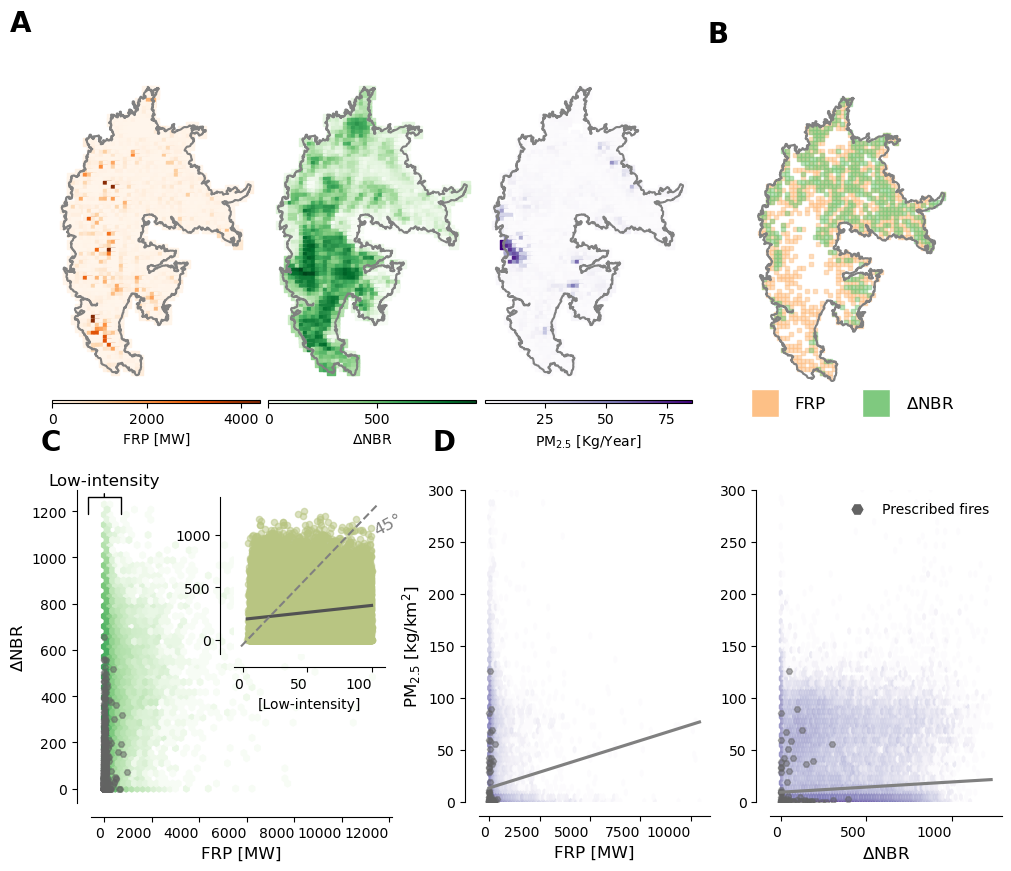

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# For illustrator to understand the font, we need to pass this!
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

plt.rcParams["font.size"] = 10

fig = plt.figure(figsize=(10, 8.5), layout="compressed")
spec = fig.add_gridspec(2, 3)

################################################################################
############################# PLOT FIRE DYNAMICS MAPS ##########################
################################################################################

subspec = GridSpecFromSubplotSpec(1, 3, subplot_spec=spec[0, 0:-1])

# Plot FRP
ax = fig.add_subplot(subspec[0, 0])
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="1%", pad=0.1)

mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax, color="Grey")
fire.plot(
    column="frp",
    legend=True,
    cmap="Oranges",
    marker=",",
    ax=ax,
    cax=cax,
    legend_kwds={"label": "FRP [MW]", "orientation": "horizontal"},
)

template_plots(ax, xlab="", ylab="", label="A", no_axis=True)

# Plot dNBR
ax = fig.add_subplot(subspec[0, 1])
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="1%", pad=0.1)

mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax, color="Grey")
fire.plot(
    column="dnbr",
    legend=True,
    cmap="Greens",
    ax=ax,
    marker=",",
    cax=cax,
    legend_kwds={"label": r"$\Delta$NBR", "orientation": "horizontal"},
)
template_plots(ax, xlab="", ylab="", no_axis=True)

# Plot emissions
ax = fig.add_subplot(subspec[0, 2])
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="1%", pad=0.1)

mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax, color="Grey")
fire.plot(
    column="PM25",
    legend=True,
    cmap="Purples",
    ax=ax,
    marker=",",
    cax=cax,
    legend_kwds={"label": r"PM$_{2.5}$ [Kg/Year]", "orientation": "horizontal"},
)
template_plots(ax, xlab="", ylab="", no_axis=True)

# Plot treatments
ax = fig.add_subplot(spec[0, 2])

mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax, color="Grey")

# Plot with divergent color scheme
fire[fire.treat_intensity == 1].plot(
    marker=",", legend=False, ax=ax, color="#fdc086", alpha=0.5, markersize=8
)
# Plot with divergent color scheme
fire[fire.treat_severity == 1].plot(
    marker=",", legend=False, ax=ax, color="#7fc97f", alpha=0.5, markersize=8
)

template_plots(ax, xlab="", ylab="", label="B", no_axis=True)

ax.legend(
    [
        plt.Line2D(
            [1],
            [0],
            marker="s",
            color="w",
            markerfacecolor="#fdc086",
            markersize=20,
        ),
        plt.Line2D(
            [1],
            [10],
            marker="s",
            color="w",
            markerfacecolor="#7fc97f",
            markersize=20,
        ),
    ],
    ["FRP", r"$\Delta$NBR"],
    fontsize=12,
    frameon=False,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
)

################################################################################
########################### DNBR and FRP relationship ##########################
################################################################################

ax = fig.add_subplot(spec[1, 0])

# Create an inset plot to the main plot located to the top right
axins = inset_axes(ax, width="50%", height="50%", loc=1)

# Transform the data to plot a 2-d hexbin using matplotlib
fires.plot.hexbin(
    x="frp",
    y="dnbr",
    cmap="Greens",
    ax=ax,
    gridsize=50,
    bins="log",
    colorbar=False,
)

# Plot the prescribed fires in gray
fires[(fires["prescribed"] == 1)].plot.scatter(
    x="frp",
    y="dnbr",
    c="#636363",
    ax=ax,
    alpha=0.5,
    colorbar=False,
    fontsize=10,
    marker="H",
)

template_plots(ax, xlab="FRP [MW]", ylab=r"$\Delta$NBR", label="C")


# Insert an annotation with an arrowprop
ax.annotate(
    "Low-intensity",
    xy=(0, 1250),
    xytext=(0, 1300),
    ha="center",
    va="bottom",
    fontsize=12,
    arrowprops=dict(arrowstyle="-[, widthB=1.0, lengthB=1.0", lw=1, color="k"),
)

# Inlet plot
plt.rcParams.update({"font.size": 14})
fires[fires["treat_intensity"] == 1].plot.scatter(
    x="frp",
    y="dnbr",
    c="#B8C582",
    ax=axins,
    alpha=0.5,
    colorbar=False,
    fontsize=10,
)

sns.regplot(
    x="frp",
    y="dnbr",
    data=fires[fires["treat_intensity"] == 1],
    scatter=False,
    ax=axins,
    color="#525252",
    robust=False,
)
template_plots(axins, xlab="", ylab="", diag=True)

# Add text in the same color over the 45-degree.
axins.text(100, 1000, "45°", rotation=28, color="gray", fontsize=12)
axins.set_title("[Low-intensity]", fontsize=10, y=-0.4)


################################################################################
####################### EMISSIONS AND INTENSITY/SEVERITY #######################
################################################################################

subspec = GridSpecFromSubplotSpec(1, 2, subplot_spec=spec[1, 1:3])
ax = fig.add_subplot(subspec[0, 0])

# ax = fig.add_subplot(spec[1, 1])

fires.plot.hexbin(
    "frp",
    "PM25",
    ax=ax,
    alpha=0.8,
    gridsize=80,
    bins="log",
    colorbar=False,
    cmap="Purples",
)
# Set y-axis limit to 1000
ax.set_ylim(0, 300)

# Color hex in gray if frp is less than 100
fires[fires.prescribed == 1].plot.scatter(
    "dnbr",
    "PM25",
    ax=ax,
    alpha=0.5,
    marker="H",
    color="#636363",
)

# Add regression line w/ seaborn
sns.regplot(
    x="frp",
    y="PM25",
    data=fires,
    scatter=False,
    color="gray",
    ax=ax,
    ci=True,
    robust=False,
)
template_plots(ax, xlab="FRP [MW]", ylab=r"PM$_{2.5}$ [kg/km$^2$]", label="D")

ax = fig.add_subplot(subspec[0, 1], sharey=ax)
# ax = fig.add_subplot(spec[1, 2])

fires.plot.hexbin(
    "dnbr",
    "PM25",
    ax=ax,
    alpha=0.8,
    gridsize=80,
    bins="log",
    colorbar=False,
    cmap="Purples",
)

# Set y-axis limit to 1000
ax.set_ylim(0, 300)

# Color hex in red if frp is less than 100
fires[fires.prescribed == 1].plot.scatter(
    "dnbr",
    "PM25",
    ax=ax,
    alpha=0.5,
    marker="H",
    color="#636363",
)

# Add regression line w/ seaborn
sns.regplot(
    x="dnbr",
    y="PM25",
    data=fires,
    scatter=False,
    color="gray",
    ax=ax,
    ci=True,
    robust=True,
)

template_plots(ax, ylab="", xlab=r"$\Delta$NBR")

# Add a legend with a single red hexagon for the treatment
ax.legend(
    [
        plt.Line2D(
            [1],
            [0],
            marker="H",
            color="w",
            markerfacecolor="#636363",
            markersize=10,
        ),
    ],
    ["Prescribed fires"],
    fontsize=10,
    frameon=False,
)
# add an alpha to see if the severity agrees w/ intensity.
plt.savefig(
    "../figs/scatter_potential_fig1.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)